# **Sentiment Analysis**
- In this notebook we carry out a sentiment analysis on reviews data from Amazon and Yelp.
- In this notebook will make use of sub words.
- To take advantage of the sequence, will be using bi-directional LSTM layers.

## **Libraries**
- Now will import libraries and dependances used in this notebook.
- We will user tensorflow and its preprocessing function for text data.
- Will also use pandas and numpy in preprocessing the data.

In [65]:
import io
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_datasets as tfds

import matplotlib.pyplot as plt

In [66]:
Tokenizer = tf.keras.preprocessing.text.Tokenizer
pad_sequences =  tf.keras.preprocessing.sequence.pad_sequences
keras = tf.keras
Sequential = tf.keras.Sequential

## **Import Data**
- The data will be using in this notebook was pulled from kaggle, cleaned and saved on google drive.
- We will now download the data used in this notebook which is saved on google drive.

In [67]:
!wget --no-check-certificate \
    -O /tmp/sentiment.csv https://drive.google.com/uc?id=13ySLC_ue6Umt9RJYSeM2t-V0kCv-4C-P

--2022-07-22 13:14:03--  https://drive.google.com/uc?id=13ySLC_ue6Umt9RJYSeM2t-V0kCv-4C-P
Resolving drive.google.com (drive.google.com)... 108.177.119.100, 108.177.119.139, 108.177.119.101, ...
Connecting to drive.google.com (drive.google.com)|108.177.119.100|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-08-ak-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/ki54gcv2qvrvarptcf696t10stps4frk/1658495625000/11118900490791463723/*/13ySLC_ue6Umt9RJYSeM2t-V0kCv-4C-P?uuid=26da8569-18ed-40d3-98d1-3f7dfe14b00e [following]
--2022-07-22 13:14:03--  https://doc-08-ak-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/ki54gcv2qvrvarptcf696t10stps4frk/1658495625000/11118900490791463723/*/13ySLC_ue6Umt9RJYSeM2t-V0kCv-4C-P?uuid=26da8569-18ed-40d3-98d1-3f7dfe14b00e
Resolving doc-08-ak-docs.googleusercontent.com (doc-08-ak-docs.googleusercontent.com)... 108.177.126.132, 2a00:1450:4013:c01::84
Connecting to d

In [68]:
dataset = pd.read_csv('/tmp/sentiment.csv')
dataset.head()

,Unnamed: 0,text,sentiment
0,0,So there is no way for me to plug it in here i...,0
1,1,Good case Excellent value.,1
2,2,Great for the jawbone.,1
3,3,Tied to charger for conversations lasting more...,0
4,4,The mic is great.,1


## **Preprocessing**
- Now will preprocess our data.
- Firstly will convert the different column in dataset into lists.

In [69]:
sentences = dataset['text'].tolist()
labels = dataset['sentiment'].tolist()

## **Creating the subwords dataset**
- Now will create the subwords dataset with vocal_size of 1000 and at most 5 characters per subword.

In [70]:
vocab_size = 1000
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(sentences, vocab_size, max_subword_length = 5)

In [71]:
num = 5 
print(sentences[5])
encoded = tokenizer.encode(sentences[num])
print(encoded)

for i in encoded:
  print(tokenizer.decode([i]))

I have to jiggle the plug to get it to line up right to get decent volume.
[4, 31, 6, 849, 162, 450, 12, 1, 600, 438, 775, 6, 175, 14, 6, 55, 213, 159, 474, 775, 6, 175, 614, 380, 295, 148, 72, 789]
I 
have 
to 
j
ig
gl
e 
the 
pl
ug
 
to 
get 
it 
to 
li
ne 
up 
right
 
to 
get 
dec
ent 
vo
lu
me
.


__Comments__
- Now will split both the sentences and labels into training and testing datasets.
- We make 80% of the data our trainning set and 20% testing set.
- We will also convert our train and testing list into numpy array for tensorflow.

### ### **Tokenization**
- Now will replace the sentences data with the encoded subwords

In [72]:
for i, sentence in enumerate(sentences):
  sentences[i] = tokenizer.encode(sentence)

print(sentences[1])

[625, 677, 626, 274, 380, 633, 148, 844, 789]


__Comments__
- Will finish the rest of the preprocessing.
- Here are some of the parameters will be using
  1. Maximum length of our sequences will be 50
  2. We will use post padding for sequences less than 100 and post truncating for sequence with words greater than 50.


In [73]:
#vocab_size = 500
max_length = 50
padding_type = 'post'
trunc_type = 'post'
#oov_tok = '<OOV>'

In [74]:
training_size = int(len(sentences)*0.8)

training_sentences = sentences[0:training_size]
testing_sentences = sentences[training_size:]

training_labels = labels[0:training_size]
testing_labels = labels[training_size:]

training_labels_np = np.array(training_labels)
testing_labels_np = np.array(testing_labels)

In [75]:
padded_training_sequences = pad_sequences(training_sentences, maxlen = max_length, 
                                          padding = padding_type, truncating = trunc_type)

padded_testing_sequences = pad_sequences(testing_sentences, maxlen = max_length, 
                                          padding = padding_type, truncating = trunc_type)

__Comments__
- Now will review our preprocessing results.
- We check the value in the word index of words appearing the sentence shown.

In [76]:
print('1st sentence: ', training_sentences[:1])
print('1st padded training sequences: ', padded_training_sequences[:1])

1st sentence:  [[736, 168, 775, 7, 193, 417, 17, 94, 6, 600, 438, 775, 14, 19, 141, 19, 1, 828, 826, 775, 99, 445, 4, 174, 361, 5, 79, 227, 139, 789]]
1st padded training sequences:  [[736 168 775   7 193 417  17  94   6 600 438 775  14  19 141  19   1 828
  826 775  99 445   4 174 361   5  79 227 139 789   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0]]


__Comments__
- Now will check the labels.

## **Sentiment Model**
- Now that we are done with preprocessing our data, we now build our model for sentiment classifications.
- For this will make use of the Embedding layer and bi-directional LSTM layer in tensorflow keras.
- This will make each unique sub-word in our vocabular a vector in the embedding dimension.
- This will allow the model to determine the how those sub-words appear in negative or positive sentiments.

In [77]:
embedding_dim = 16

__Comments__
- Our model will have the following layers.
  1. The input layers will be the Embedding layers and the input length will match the maximum length for each sequence.
  2. The results of embedding layer are then feed into a bi-directional layer with 16 units.
  3. Will flatten the results of the embedding layer to move it for the 16 dimension to the 2D for the following dense layers.
  4. Now will have a dense layer with 16 units and relu activation
  5. The output layer is a dense layer with 1 unit as have to output states and has sigmoid activation function for binary classification.

In [78]:
model = Sequential([
                    keras.layers.Embedding(vocab_size, embedding_dim, input_length = max_length),
                    keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim)),
                    keras.layers.Dense(16, activation = 'relu'),
                    keras.layers.Dense(1, activation = 'sigmoid')
])
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 50, 16)            16000     
                                                                 
 bidirectional_3 (Bidirectio  (None, 32)               4224      
 nal)                                                            
                                                                 
 dense_6 (Dense)             (None, 16)                528       
                                                                 
 dense_7 (Dense)             (None, 1)                 17        
                                                                 
Total params: 20,769
Trainable params: 20,769
Non-trainable params: 0
_________________________________________________________________


### **Compiling and Trainning**

- In order to make it easy to try models of different architure and hyperparameters we will create a function that will compile, train and show results of each model we pass to it.
- This is possible to the consistance of how we will compile and train our models.

#### **Model Compiling**
- For compling our model will make use of the binary cross enthropy loss function.
- We will also use the adam optimizer and accuracy as our metric to measure.

In [79]:
def plot_results(model_history, metric):
  plt.plot(model_history.history[metric], label = metric)
  plt.plot(model_history.history['val_'+metric], label = 'val_'+metric)
  plt.xlabel('EPOCHS')
  plt.ylabel(metric)
  plt.show()

In [80]:
def fit_model_and_show_results(model, EPOCHS):
  model.compile(loss = keras.losses.BinaryCrossentropy(), # from_logits = True
              optimizer = 'adam', metrics = ['accuracy'])
  history = model.fit(padded_training_sequences, training_labels_np, epochs = EPOCHS,
          validation_data = (padded_testing_sequences, testing_labels_np), verbose = 0)
  plot_results(history, 'accuracy')
  plot_results(history, 'loss')

### **Training Model**

- Now will train our model using 30 epochs.

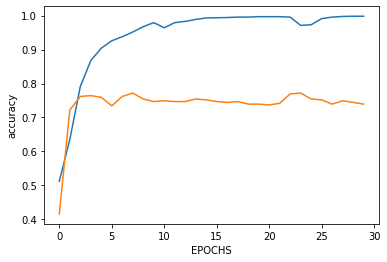

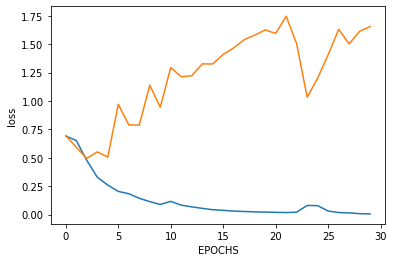

In [81]:
EPOCHS = 30
fit_model_and_show_results(model, EPOCHS)

### **Model Performance**
- Look at the accuracy, althogth the accuracy on the train sequence increased to above 95%, the accuracy on the test sequence reach just above 75% and start to decrease.
- Looking at the loss of the test sequence unlike that of the train sequence it started to increase.
- This is a indication of our model over fitting on the train data.
- We now look at how the model performs on some fake review we will generate.
- To do this will create a function that take in the fake review, apply the preprocessing we did on the train and test data then predict using the model.

In [82]:
def predict_review(model, fake_sentences, max_length = 50, padding_type = 'post', trunc_type = 'post'):
  # Creating the sub-words from our sentences
  new_sentences = []
  for i, sentence in enumerate(fake_sentences):
    new_sentences.append(tokenizer.encode(sentence))

  # Creating the sequences making use of the parameters we used before
  sequences = pad_sequences(new_sentences, maxlen = max_length, 
                            padding = padding_type, truncating = trunc_type)

  # Predicting the sentiment of our sequences
  classes = model.predict(sequences)

  # Showing our sentences and the likelihood of it being a positive sentiment.
  # Remember on training the positive sentiment has a label of 1 and negative has 0, 
  # hence the predict show values range from 0 to 1.
  for i in range(len(fake_sentences)):
    print(fake_sentences[i])
    print(classes[i])
    print('\n')

__Comments__
- Now will create some fake reviews

In [83]:
fake_reviews = [
                'I enjoy and will sure go back',
                'As far as experiences go, that was a nightmare',
                'Worked as advertised',
                'The biggest worst of money',
                'Performed as expect for the low price',
                'Maybe i got unlucky',
                'I recommend it to all my friends and family'
                ]

In [84]:
predict_review(model,fake_reviews)

I enjoy and will sure go back
[0.99989533]


As far as experiences go, that was a nightmare
[0.01847464]


Worked as advertised
[0.00357174]


The biggest worst of money
[0.00016016]


Performed as expect for the low price
[0.00259193]


Maybe i got unlucky
[0.0055697]


I recommend it to all my friends and family
[1.]




### **Another Model**
- Now will try a model with two Bi-directional LSTM layers stacked one after the other.
- For this the LSTM layer we need to return a sequence for the second LSTM layer.

In [86]:
model2 = Sequential([
                     keras.layers.Embedding(vocab_size, embedding_dim, input_length = max_length),
                     keras.layers.Bidirectional( keras.layers.LSTM(embedding_dim, return_sequences = True)),
                     keras.layers.Bidirectional( keras.layers.LSTM(embedding_dim)),
                     keras.layers.Dense(16, activation = 'relu'),
                     keras.layers.Dense(1, activation = 'sigmoid')
])
model2.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 50, 16)            16000     
                                                                 
 bidirectional_4 (Bidirectio  (None, 50, 32)           4224      
 nal)                                                            
                                                                 
 bidirectional_5 (Bidirectio  (None, 32)               6272      
 nal)                                                            
                                                                 
 dense_8 (Dense)             (None, 16)                528       
                                                                 
 dense_9 (Dense)             (None, 1)                 17        
                                                                 
Total params: 27,041
Trainable params: 27,041
Non-trai

__Comments__
- Now will compile, train and show results of the new model.

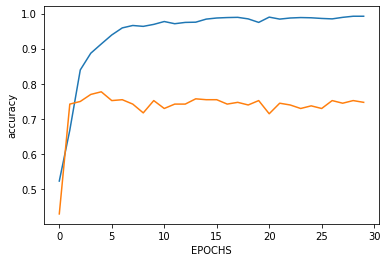

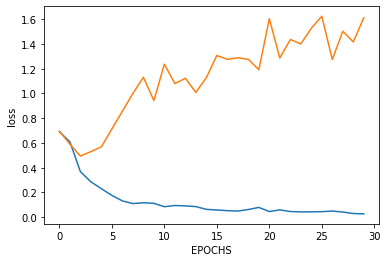

In [87]:
fit_model_and_show_results(model2, EPOCHS)

#### **Model Performance**
- Adding a second LSTM layer did not signficantly change how the model performs.
- After that will look at how our model performs on the fake reviews we made.


In [88]:
predict_review(model2,fake_reviews)

I enjoy and will sure go back
[0.9999894]


As far as experiences go, that was a nightmare
[0.00432537]


Worked as advertised
[0.00557249]


The biggest worst of money
[0.01104686]


Performed as expect for the low price
[0.0048673]


Maybe i got unlucky
[0.00444144]


I recommend it to all my friends and family
[0.99999595]




### Visualising Network
- Now will data to visualize the embedding and see each word relative to the sentiment on the site http://projector.tensorflow.org/ for both models.

In [89]:
multiple_models = [model, model2]
for i in range(len(multiple_models)):
  e = multiple_models[i].layers[0]
  weights = e.get_weights()[0]

  out_v = io.open(f'vecs_{i}.tsv', 'w', encoding = 'utf-8')
  out_m = io.open(f'meta_{i}.tsv', 'w', encoding = 'utf-8')
  for word_num in range(0, vocab_size-1):
    word =tokenizer.decode([word_num])
    embeddings = weights[word_num]
    out_m.write(word + '\n')
    out_v.write('\t'.join([ str(x) for x in embeddings]) + '\n')

  out_v.close()
  out_m.close()

  try:
    from google.colab import files
  except ImportError:
    pass
  else:
    files.download(f'vecs_{i}.tsv')
    files.download(f'meta_{i}.tsv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## **Conclusion**
- Introducing LSTM is not impove much of the perfomance of our model.
- To combate the over fitting show on the loss graphs, we might need to introduce early stopping.
- When we visualise the embedding of the sub-words
  - For the first model the sub-word are all over the place almost forming three clusters instead of two.
  - For the second model we do have two cluster but they not heavily pronounced.